# 2018 10 30 Des Gabors pour V1
Finalement j'ai fini par regarder le github de NeuralEnsemble et il se trouve qu'ils avaient un code qui accompagne le blog. Ca serait trop simple de copier coller après tout le mal qu'on s'est donné mais par contre je peux reprendre la grande idée qui était d'assembler des filtres en gabor pour faire des V1 sensibles à une orientation particulière.

Bon au pire si ça prend trop de temps je forkerai directement de chez eux.

# J'ai fais une bourde dans les scatter, la bonne taille de champ (3°) est 20**2

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

video = np.load('./LifeOfBrian_29.97FPS.npy').T
video = np.rot90(video)
print('Video shape', video.shape)

Video shape (36, 64, 640)


In [12]:
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss



############
# Constants
############
total_time = 1000 #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

coo_min = len(video[:,:,0])/2 - 5
coo_max = len(video[:,:,0])/2 + 5
grid_res = 2.

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res,coo_min:coo_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)

Filter array size (25, 2)


Video shape (36, 64, 640)
Frames shape (36, 64)


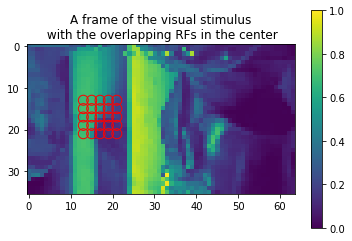

In [13]:
print('Video shape', video.shape)
print('Frames shape',video[:,:,0].shape)
plt.imshow(video[:,:,0], cmap = plt.cm.viridis)
plt.colorbar()
for filt in filters_coordinates :
    plt.scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')

plt.title('A frame of the visual stimulus\n with the overlapping RFs in the center')
#plt.savefig('./figs/2018_10_24_MontyPython_frame.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show()

# Génerer un Gabor et y associer des filtres

In [14]:
parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

In [45]:
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X)
N_Y = int(N_Y)

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.05, 'B_sf': .5, 'B_theta': B_theta}

N_phase = 2
theta = 3*np.pi/4
phi = np.zeros((1, N_phase, N_X, N_Y))

x = N_X/2 #gabor centered
y = N_Y/2
params.update(theta=theta)
for i_phase in range(N_phase):
    phase = i_phase * np.pi/2
    kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
    phi[0, i_phase, :] = lg.normalize(kernel)

In [46]:
threshold = .6

gab_above_threshold = np.array([*np.where(phi[0,0] > threshold)], dtype = float).T #one-lineeeeer
print('There are %s points in the Gabor above the threshold' % str(gab_above_threshold.shape[0]))

filters_in_gabor = []
for it, filt in enumerate(filters_coordinates) :
    for gabs in gab_above_threshold :
        if np.all(filt.astype(int) == gabs):# or np.all(filt == gabs+.5) or np.all(filt == gabs-.5):
            filters_in_gabor.append(filt)
        
print('%s/%s ST filters are in the Gabor' % (len(filters_in_gabor),len(filters_coordinates) ))

There are 55 points in the Gabor above the threshold
0/25 ST filters are in the Gabor


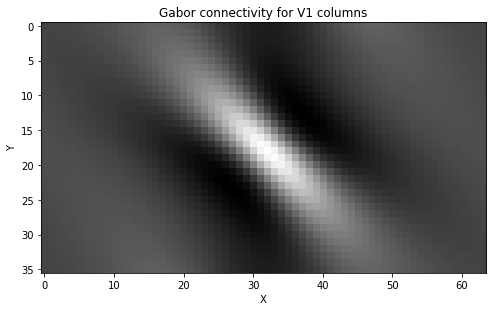

In [47]:
fig, ax = plt.subplots(figsize = (7,6))
ax.imshow(phi[0,0], cmap=plt.gray()) #[theta_nbr, phase, content]
#fig.colorbar(ax.contourf(phi[0,0], cmap=plt.gray()))

for filt in filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'r')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gabor connectivity for V1 columns')
plt.tight_layout()

# Dans une fonction

In [8]:
def gabor_connectivity(filters, phi, theta, threshold, on = True):
    '''
    From an array of filters and a gabor phi-space, returns the filters in the phi-space above a threshold
    Args :
        Filters (ndarray) : A 2D array of filters to localize on the gabor
        Phi : A phi space from a LogGabor
        Theta : 
    '''
    if on : gab_above_threshold = np.array([*np.where(phi[theta,0] > threshold)], dtype = float).T
    else :gab_above_threshold = np.array([*np.where(phi[theta,0] < threshold)], dtype = float).T

    filters_in_gabor = []
    for it, filt in enumerate(filters_coordinates) :
        for gabs in gab_above_threshold :
            if np.all(filt.astype(int) == gabs): filters_in_gabor.append(filt)

    return filters_in_gabor

In [9]:
filters_in_gabor = gabor_connectivity(filters_coordinates, phi, 0, .6)

# Essai avec un Gabor en ripple
C'est mieux quand sf_0 proche de B_sf

In [10]:
parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

In [11]:
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X)
N_Y = int(N_Y)

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.075, 'B_sf': .07, 'B_theta': B_theta}

N_phase = 2
theta = 3*np.pi/4
phi = np.zeros((1, N_phase, N_X, N_Y))

x = N_X/2 #gabor centered
y = N_Y/2
params.update(theta=theta)
for i_phase in range(N_phase):
    phase = i_phase * np.pi/2
    kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
    phi[0, i_phase, :] = lg.normalize(kernel)

In [12]:
coo_min = len(video[:,:,0])/2 - 25
coo_max = len(video[:,:,0])/2 + 25
grid_res = 3

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res,coo_min:coo_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)

Filter array size (289, 2)


In [13]:
filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                      phi = phi,theta =  0, threshold =0)

off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                      phi = phi,theta =  0, threshold =0, on = False)

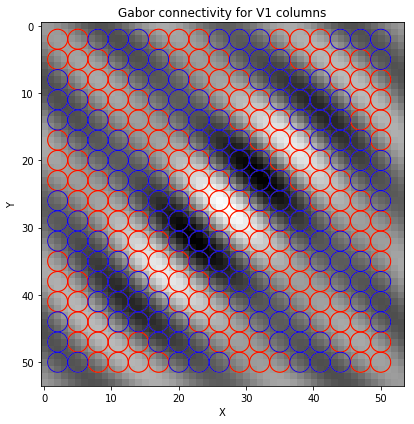

In [14]:
fig, ax = plt.subplots(figsize = (7,6))
ax.imshow(phi[0,0], cmap=plt.gray()) #[theta_nbr, phase, content]
#fig.colorbar(ax.contourf(phi[0,0], cmap=plt.gray()))

for filt in filters_coordinates :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'orange',
               alpha = .8)
    
for filt in filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'red')
    
for filt in off_filters_in_gabor :
    ax.scatter(filt[0], filt[1], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'blue')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gabor connectivity for V1 columns')
plt.tight_layout()

# Comparison time !
QUATRES OPTIONS : Faire des plusieurs petits Gabors pour chaque orientation qui recouvrent tout l'image, comme on trouve dans V1 (c'est les champs classique au sens H&W) 

OU faire un seul gros gabor avec une découpage de l'image pour l'orientaiton, dans ce cas c'est une mégacolonne qui prend toutes les orientations (qu'on peut justifier par la simplification)

ET pour chaque cas recouvrement ou pas des champs (facteur résolution en fait)

Supposons 12 thetas comme dans OBV1 : Dans le cas des petits Gabor il faudra au moins 12 gabor pour recouvrir tout l'espace (au pifomètre), ce qui donnerait 124 cellules V1 par orientation, chacune comprenant environ 50 RF ON et OFF, donc 6000 RF a simuler

Dans le cas du gros filtre, c'est 12 * 1 * (20 * 12)  = 2k8 c'est pas non plus beaucoup mieux..

## Résultats : on est en effet sur presque le triple du temps pour les petits filtres, mais ils permettent de simuler des cellules simples de V1, donc du vrai biolike.. 
## Il suffit de tout passer en multiprocessing, voir notebook du 2 nov !

### D'ailleurs pourquoi des colonnes si les cellules suffisent ? Chercher un papier (redondance, stabilité, topologie au sens Kohonen ?)

# Comparison 1 : One big Gabor per orientation AKA Full Field Gabor
## Laptop : Wall time: 1min 56s
Simplifié en 25 RF par orientation 

In [15]:
%%time
# GABOR
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X)
N_Y = int(N_Y)

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 15 /180 * np.pi
params= {'sf_0':.075, 'B_sf': .07, 'B_theta': B_theta}

N_theta, N_phase = 12, 2
theta = np.linspace(0, np.pi, N_theta)

phi = np.zeros((N_theta, N_phase, N_X, N_Y))

for i_theta in range(N_theta):
    x = N_X/2
    y = N_Y/2
    params.update(theta=i_theta*np.pi/N_theta)
    for i_phase in range(N_phase):
        
        phase = i_phase * np.pi/2
        kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
        phi[i_theta, i_phase, :] = lg.normalize(kernel)
        
        
        
#CONSTANTS
total_time = 1000 #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

distrib_size = 8
fx_min = x - distrib_size
fx_max = x + distrib_size
fy_min = y - distrib_size
fy_max = y + distrib_size
grid_res = 3

filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,fy_min:fy_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)  

filters_per_theta = []
stimuli = video
#FILTERS IN GABOR
for theta in tqdm(range(N_theta), 'Iterating through thetas') :
    filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                          phi = phi,theta =  theta, threshold =0)

    off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                          phi = phi,theta =  theta, threshold =0, on = False)
    
    #CAlCULER TOUT LES FILTRES
    convo_list = []
    st_list = []
    on_st_levels = []
    
    #LES FILTRES ON 
    for filt in range(len(filters_in_gabor)):
        X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                               xres = filter_res, yres = filter_res,
                               x_trans= filters_in_gabor[filt][0],
                              y_trans = filters_in_gabor[filt][1]) 
        t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

        #Convolution coordinates, centered around the filter and the size of the filter space
        X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
        X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
        Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
        Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)

        activations = []
        for i in np.linspace(0, total_time-1, total_time):
            activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                      *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

        ys = np.convolve(t, activations)
        st = Z[:, :, None] * ys[None, None, :]

        convo_list.append(ys)
        st_list.append(st)
        
        on_st_level = []
        for i in range(total_time):
            on_st_level.append(np.max(st[:,:,i]))
        on_st_levels.append(on_st_level)
        
    convo_list = []
    st_list = []
    off_st_levels = []
    
    #LES FILTRES OFF 
    for filt in range(len(off_filters_in_gabor)):
        X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                               xres = filter_res, yres = filter_res,
                               x_trans= off_filters_in_gabor[filt][0],
                              y_trans = off_filters_in_gabor[filt][1],
                              end_multiplier = 1.) 
        t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

        #Convolution coordinates, centered around the filter and the size of the filter space
        X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
        X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
        Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
        Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)

        activations = []
        for i in np.linspace(0, total_time-1, total_time):
            activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                      *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

        ys = np.convolve(t, activations)
        st = Z[:, :, None] * ys[None, None, :]

        convo_list.append(ys)
        st_list.append(st)
        
        off_st_level = []
        for i in range(total_time):
            off_st_level.append(np.max(st[:,:,i]))
        off_st_levels.append(off_st_level)
    
    filters_per_theta.append((on_st_levels, off_st_levels))

Iterating through thetas:   0%|          | 0/12 [00:00<?, ?it/s]

Filter array size (36, 2)


Iterating through thetas: 100%|██████████| 12/12 [02:01<00:00, 10.17s/it]

CPU times: user 1min 51s, sys: 10.9 s, total: 2min 2s
Wall time: 2min 2s


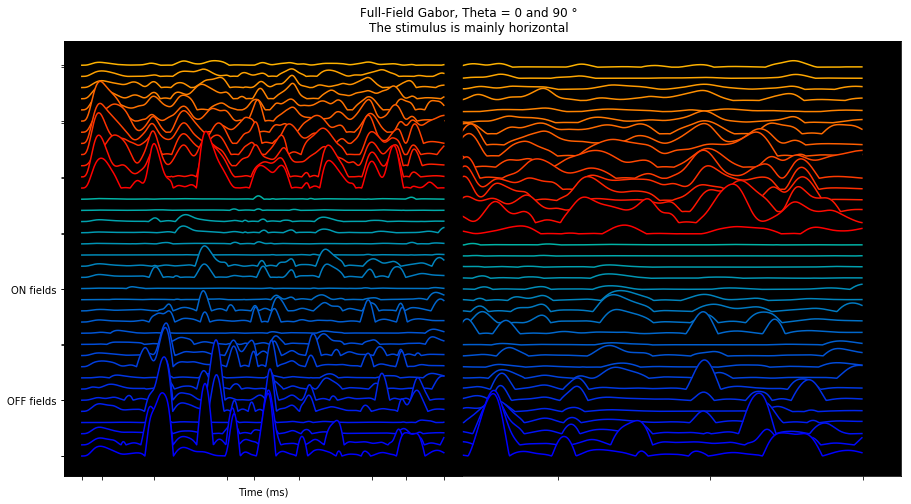

In [16]:
import numpy as np
import pylab as plt
import itertools

theta_nbr = 10

on_st_levels = filters_per_theta[theta_nbr][0]
off_st_levels = filters_per_theta[theta_nbr][1]
chans = len(on_st_levels) + len(off_st_levels) #channels

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

ax.set_facecolor('black')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 10

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
ax.set_yticklabels(['','','OFF fields','','' 'ON fields'])

ax.set_xticklabels([])

ax = fig.add_subplot(1, 2,1)
theta_nbr = 6

on_st_levels = filters_per_theta[theta_nbr][0]
off_st_levels = filters_per_theta[theta_nbr][1]
chans = len(on_st_levels) + len(off_st_levels) #channels


ax.set_facecolor('black')

on_colors=plt.cm.autumn(np.linspace(0,.7,len(on_st_levels)))
off_colors=plt.cm.winter(np.linspace(0,.7,len(off_st_levels)))

on_arr = np.asarray(on_st_levels)
off_arr = np.asarray(off_st_levels)
divby = 10

for channel in range(chans):
    if channel < len(off_st_levels) :
        plt.fill_between(np.linspace(0, len(on_st_levels[0]), len(on_st_levels[0])),
                         off_arr[channel]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(off_arr[channel]+channel/divby, zorder = chans-channel,
                color = off_colors[channel])
    else : 
        plt.fill_between(np.linspace(0, len(off_st_levels[0]), len(off_st_levels[0])),
                         on_arr[channel-len(off_st_levels)]+channel/divby, channel/divby,
                         facecolor='black',
                         zorder = chans-channel)
        plt.plot(on_arr[channel-len(off_st_levels)]+channel/divby, zorder = chans-channel,
                color = on_colors[channel-len(off_st_levels)])
        

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.xlabel('Time (ms)')
plt.suptitle(x = .5, y = .94,t = 'Full-Field Gabor, Theta = 0 and 90 °\nThe stimulus is mainly horizontal')

plt.subplots_adjust(wspace = .1)

#plt.savefig('./figs/2018_10_30_Comparison_Large_Gabors.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show() 


# Comparison 2 : Small Gabors
## Laptop : Wall time: 4min 20s


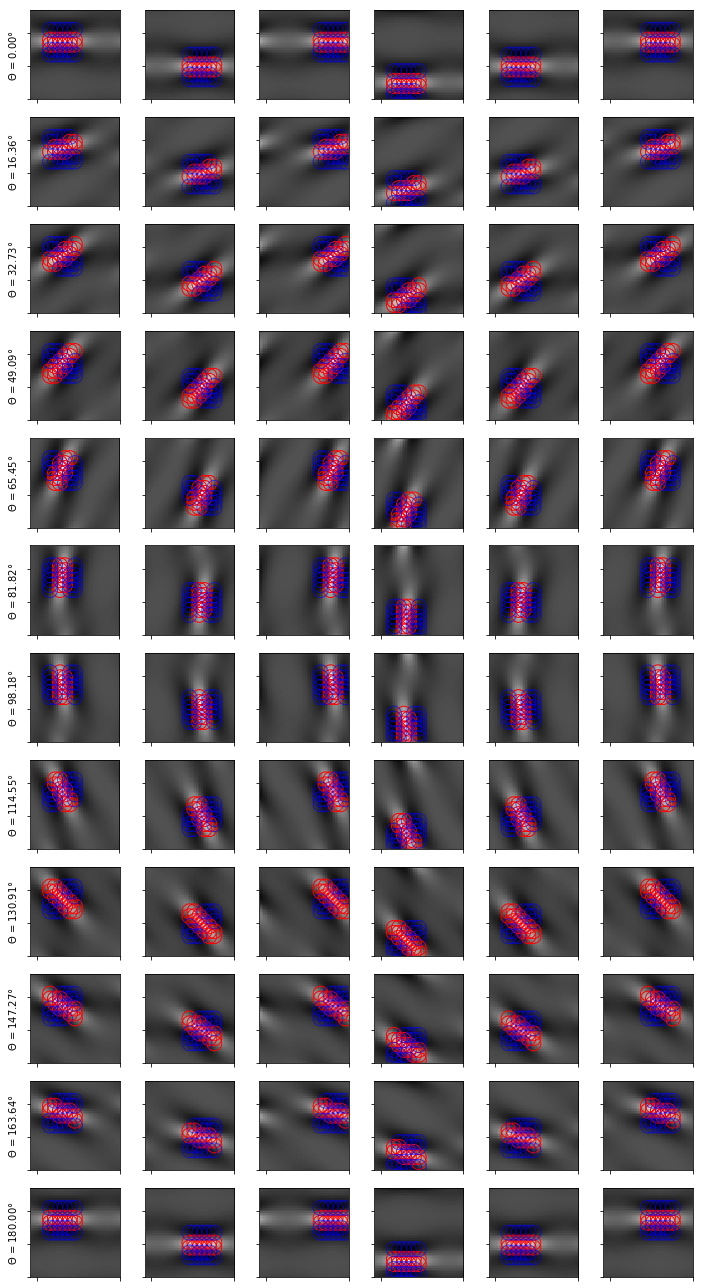

In [23]:
from LogGabor import LogGabor
import random

N_theta, N_phase = 12, 2
thetas = np.linspace(0, np.pi, N_theta)

nbr_gabors = 6 
fig, axs = plt.subplots(N_theta,nbr_gabors,figsize = (10,18))
for t in range(N_theta) :
    
    N_X, N_Y, N_frame = video.shape
    N_X = int(N_X)
    N_Y = int(N_Y)

    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))

    B_theta = 15 /180 * np.pi


    N_phase = 2
    theta = thetas[t]
    phi = np.zeros((1, N_phase, N_X, N_Y))
    params= {'sf_0':.05, 'B_sf': .5, 'B_theta': B_theta}
    params.update(theta=theta)

    
    xs = [40, 20, 40, 10, 20, 40]
    ys = [40, 20, 10, 40, 40, 20]
    
    xs = [35, 20, 35, 10, 20, 35]
    ys = [35, 20, 10, 35, 35, 20]
    
    for gab in range(nbr_gabors) :
        x = xs[gab]
        y = ys[gab]

        for i_phase in range(N_phase):
            phase = i_phase * np.pi/2
            kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
            phi[0, i_phase, :] = lg.normalize(kernel)

        distrib_size = 8
        fx_min = x - distrib_size
        fx_max = x + distrib_size
        fy_min = y - distrib_size
        fy_max = y + distrib_size
        grid_res = 3

        filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,fy_min:fy_max:grid_res].reshape(2,-1).T

        #print('Filter array size', filters_coordinates.shape)


        filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =.3)

        off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =-0.1, on = False)


        axs[t][gab].imshow(phi[0,0], cmap=plt.gray()) #[theta_nbr, phase, content]
        #fig.colorbar(ax.contourf(phi[0,0], cmap=plt.gray()))

        '''for filt in filters_coordinates :
             axs[t][gab].scatter(filt[1], filt[0], color = 'r', s = 20**2, facecolor = 'None', edgecolor = 'orange',
                       alpha = .8)'''

        for filt in filters_in_gabor :
             axs[t][gab].scatter(filt[1], filt[0], color = 'r', s = 15**2, facecolor = 'None', 
                                 edgecolor = 'red')

        for filt in off_filters_in_gabor :
             axs[t][gab].scatter(filt[1], filt[0], color = 'r', s = 15**2, facecolor = 'None', 
                                 edgecolor = 'blue', alpha = .6)
        
        axs[t][gab].set_ylabel((r"$\Theta$ = %.2f°" % (theta*180/np.pi)) if gab == 0 else '')
        axs[t][gab].set_xlim(54,0)
        axs[t][gab].set_ylim(0,54)
        axs[t][gab].set_yticklabels([])
        axs[t][gab].set_xticklabels([])
        
        

    '''plt.suptitle(x = .5, y = .7, 
                 t ='Theta = %.2f°' % (theta*180/np.pi))'''
#plt.subplots_adjust(left = .1, right = .9, bottom = .1, top = .7,hspace = .01, wspace = .01)
plt.tight_layout()
plt.savefig('./figs/2018_11_02_Gab_vs_thetas.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
    #plt.savefig('./figs/2018_11_02_GabTheta%s.pdf'%theta, format = 'pdf', bbox_inches = 'tight')
    #plt.pause(.1)

In [19]:
%%time
from LogGabor import LogGabor
import random

N_theta, N_phase = 12, 2
thetas = np.linspace(0, np.pi, N_theta)

gabors_per_theta = []
stimuli = video
# loop through thetas
for theta in tqdm(range(N_theta), 'Iterating through thetas') :
    
    N_X, N_Y, N_frame = video.shape
    N_X = int(N_X)
    N_Y = int(N_Y)

    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))

    B_theta = 15 /180 * np.pi


    N_phase = 2
    theta = thetas[theta]
    phi = np.zeros((1, N_phase, N_X, N_Y))
    params= {'sf_0':.05, 'B_sf': .5, 'B_theta': B_theta}
    params.update(theta=theta)

    nbr_gabors = 6 
    xs = [40, 20, 40, 10, 20, 40]
    ys = [40, 20, 10, 40, 40, 20]
    
    xs = [30, 20, 30, 10, 20, 30]
    ys = [30, 20, 10, 30, 30, 20]
    
    
    filters_per_theta = []
    #loop through gabors
    for gab in range(nbr_gabors) :
        x = xs[gab]
        y = ys[gab]

        for i_phase in range(N_phase):
            phase = i_phase * np.pi/2
            kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
            phi[0, i_phase, :] = lg.normalize(kernel)
        
        distrib_size = 8
        fx_min = x - distrib_size
        fx_max = x + distrib_size
        fy_min = y - distrib_size
        fy_max = y + distrib_size
        grid_res = 3

        filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,fy_min:fy_max:grid_res].reshape(2,-1).T

        #print('Filter array size', filters_coordinates.shape)


        filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =.3)

        off_filters_in_gabor = gabor_connectivity(filters = filters_coordinates,
                                              phi = phi,theta =  0, threshold =-0.1, on = False)

        #LES FILTRES ON 
        convo_list = []
        st_list = []
        on_st_levels = []

        for filt in range(len(filters_in_gabor)):
            try :
                X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                                       xres = filter_res, yres = filter_res,
                                       x_trans= filters_in_gabor[filt][0],
                                      y_trans = filters_in_gabor[filt][1]) 
                t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

                #Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)

                activations = []
                for i in np.linspace(0, total_time-1, total_time):
                    activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                              *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]

                convo_list.append(ys)
                st_list.append(st)

                on_st_level = []
                for i in range(total_time):
                    on_st_level.append(np.max(st[:,:,i]))
                on_st_levels.append(on_st_level)
            except :
                print('Error : The RF is outside the image')
                pass
        
        #LES FILTRES OFF 
        convo_list = []
        st_list = []
        off_st_levels = []

        for filt in range(len(off_filters_in_gabor)):
            try :
                X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                                       xres = filter_res, yres = filter_res,
                                       x_trans= off_filters_in_gabor[filt][0],
                                      y_trans = off_filters_in_gabor[filt][1],
                                      end_multiplier = 1.) 
                t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

                #Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)

                activations = []
                for i in np.linspace(0, total_time-1, total_time):
                    activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                              *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]

                convo_list.append(ys)
                st_list.append(st)

                off_st_level = []
                for i in range(total_time):
                    off_st_level.append(np.max(st[:,:,i]))
                off_st_levels.append(off_st_level)
            except :
                print('Error : The RF is outside the image')
                pass


        filters_per_theta.append((on_st_levels, off_st_levels))
    gabors_per_theta.append(filters_per_theta)


Iterating through thetas:  75%|███████▌  | 9/12 [03:20<01:06, 22.27s/it]

Error : The RF is outside the image
Error : The RF is outside the image
Error : The RF is outside the image
Error : The RF is outside the image


Iterating through thetas: 100%|██████████| 12/12 [04:28<00:00, 22.39s/it]

CPU times: user 4min 27s, sys: 1.13 s, total: 4min 28s
Wall time: 4min 28s


In [20]:
#the structure is weird as fuck, here is how it works.
print('We used %s thetas' % len(gabors_per_theta))
print('There is %s gabor per theta' %len(gabors_per_theta[0]))
print('There are %s types of filters per gabor' %len(gabors_per_theta[0][0]))
print('For the first theta and first gabor, we have %s ON filters' %len(gabors_per_theta[0][0][0]))

print('For the first theta and first gabor, we have %s OFF filters' %len(gabors_per_theta[0][0][1]))

We used 12 thetas
There is 6 gabor per theta
There are 2 types of filters per gabor
For the first theta and first gabor, we have 12 ON filters
For the first theta and first gabor, we have 17 OFF filters


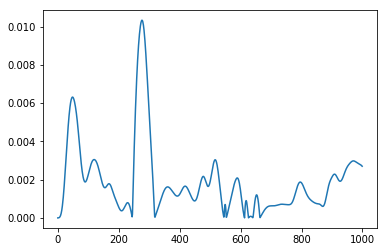

In [21]:
plt.plot(gabors_per_theta[0][1][1][2]) #theta = 0, premier gabor, RF on, deuxième RF de la liste